## Используемые библиотеки

In [3]:
# !pip3 install prophet

In [34]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from prophet.diagnostics import cross_validation, performance_metrics
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Задания

In [5]:
url = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/wiki_machine_learning.csv"
data = pd.read_csv(url, sep=" ")
data.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


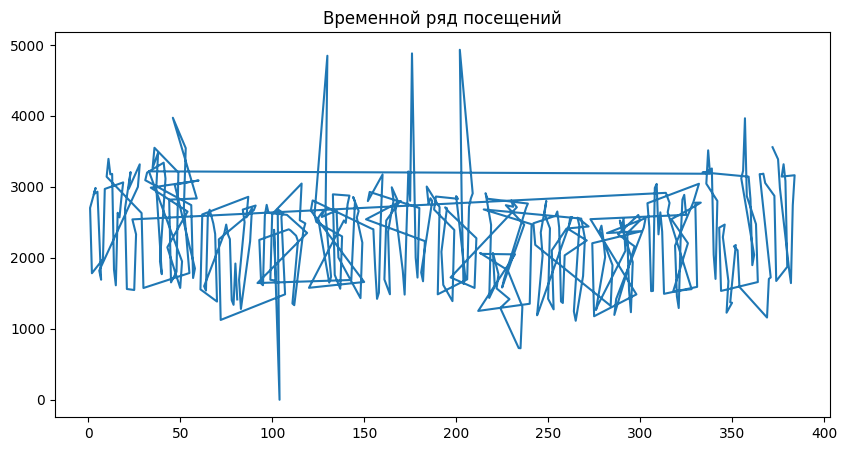

In [8]:
data['count'].plot(figsize=(10, 5))
plt.title('Временной ряд посещений')
plt.show()

In [9]:
data.columns = ['date', 'count', 'lang', 'page', 'rank', 'month', 'title']
data = data[['date', 'count']]
data['date'] = pd.to_datetime(data['date'])
data = data.rename(columns={'date': 'ds', 'count': 'y'})

### Модель

In [10]:
model = Prophet(
    changepoint_prior_scale=0.3,
    weekly_seasonality=True,
    yearly_seasonality=False
)

In [11]:
model.add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=3
)
model.fit(data)

12:33:46 - cmdstanpy - INFO - Chain [1] start processing
12:33:46 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

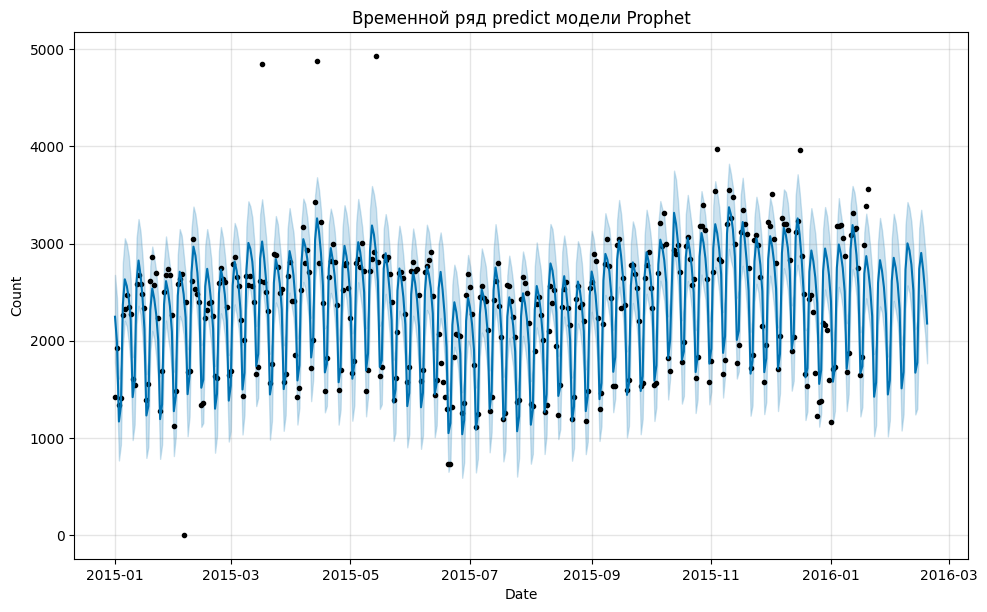

In [15]:
model.plot(forecast)
plt.title('Временной ряд predict модели Prophet')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

### Оценка качества

In [17]:
y_true = data['y'][-30:]
y_pred = forecast['yhat'][-30:]

In [18]:
mape = mean_absolute_percentage_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAPE: {mape:.2%}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MAPE: 35.19%
RMSE: 877.14
MAE: 745.95


**Обучения модели с подготовленными данными**

In [19]:
q_low = data['y'].quantile(0.1)
q_high = data['y'].quantile(0.9)
prepared_data = data[(data['y'] > q_low) & (data['y'] < q_high)]

In [22]:
model_prepared = Prophet(
    changepoint_prior_scale=0.02,
    weekly_seasonality=True, 
    yearly_seasonality=False,
    uncertainty_samples=2000
)

In [23]:
model_prepared.add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=3
)
model_prepared.fit(prepared_data)

12:40:15 - cmdstanpy - INFO - Chain [1] start processing
12:40:15 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
future_prepared = model_prepared.make_future_dataframe(periods=30)
forecast_prepared = model_prepared.predict(future_prepared)

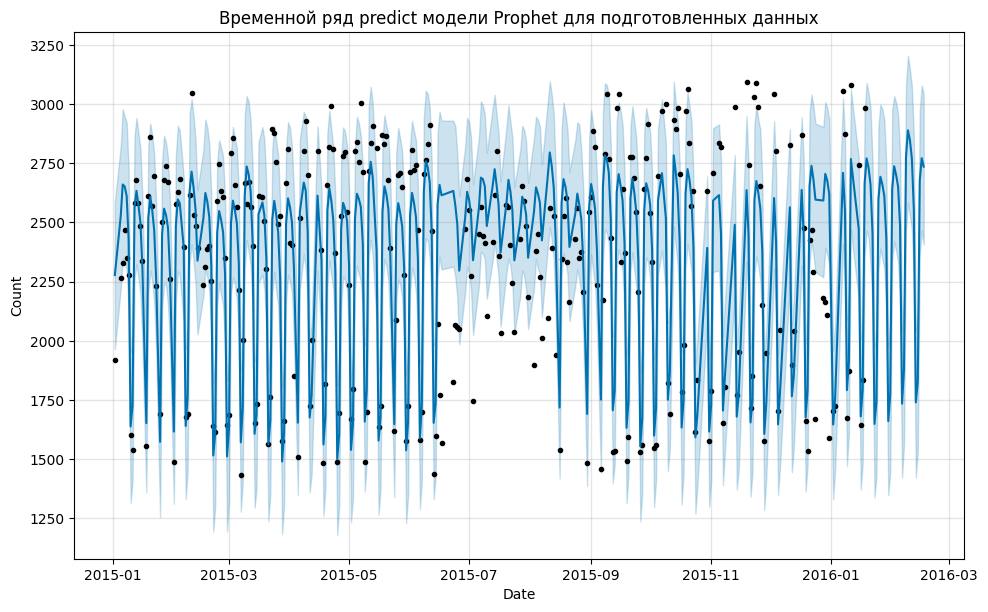

In [31]:
model_prepared.plot(forecast_prepared)
plt.title('Временной ряд predict модели Prophet для подготовленных данных')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

In [28]:
y_true_prepared = prepared_data['y'][-30:]
y_pred_prepared = forecast_prepared['yhat'][-30:]

In [29]:
mape_prepared = mean_absolute_percentage_error(y_true_prepared, y_pred_prepared)
rmse_prepared = np.sqrt(mean_squared_error(y_true_prepared, y_pred_prepared))
mae_prepared = mean_absolute_error(y_true_prepared, y_pred_prepared)

print(f"MAPE (подготовленные данные): {mape_prepared:.2%}")
print(f"RMSE (подготовленные данные): {rmse_prepared:.2f}")
print(f"MAE (подготовленные данные): {mae_prepared:.2f}")

MAPE (подготовленные данные): 29.50%
RMSE (подготовленные данные): 710.28
MAE (подготовленные данные): 596.15


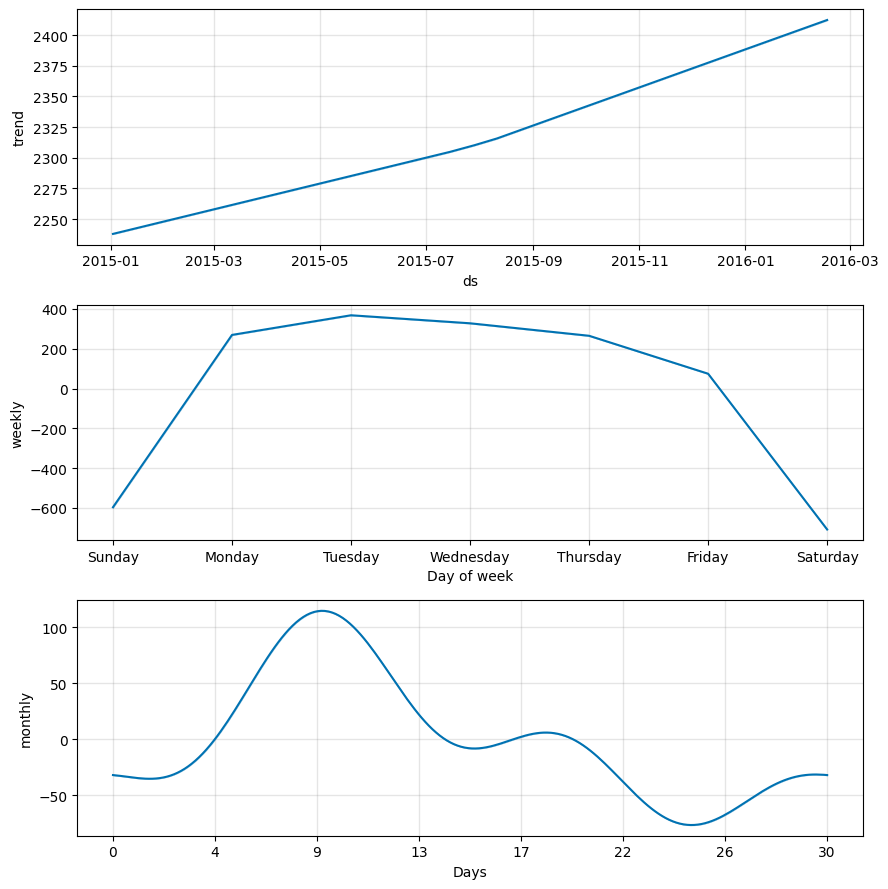

In [32]:
model_prepared.plot_components(forecast_prepared)
plt.show()

In [35]:
cross_val = cross_validation(
    model_prepared,
    initial='200 days',
    period='30 days',
    horizon='7 days'
)

  0%|          | 0/6 [00:00<?, ?it/s]

12:48:19 - cmdstanpy - INFO - Chain [1] start processing
12:48:19 - cmdstanpy - INFO - Chain [1] done processing
12:48:19 - cmdstanpy - INFO - Chain [1] start processing
12:48:19 - cmdstanpy - INFO - Chain [1] done processing
12:48:19 - cmdstanpy - INFO - Chain [1] start processing
12:48:19 - cmdstanpy - INFO - Chain [1] done processing
12:48:19 - cmdstanpy - INFO - Chain [1] start processing
12:48:19 - cmdstanpy - INFO - Chain [1] done processing
12:48:19 - cmdstanpy - INFO - Chain [1] start processing
12:48:19 - cmdstanpy - INFO - Chain [1] done processing
12:48:19 - cmdstanpy - INFO - Chain [1] start processing
12:48:19 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
cross_val_metrics = performance_metrics(cross_val)

In [37]:
cross_val_metrics

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,191647.399567,437.775513,374.441467,0.127680,0.139758,0.139634,0.25
1,2 days,162228.050675,402.775435,336.974499,0.128762,0.133600,0.139665,0.50
2,3 days,77633.447261,278.627793,217.646057,0.089766,0.067953,0.095964,0.75
3,4 days,72974.566036,270.138050,261.001457,0.112693,0.109273,0.120515,0.50
4,5 days,59634.402990,244.201562,193.187660,0.086403,0.092130,0.093394,0.60
5,6 days,54115.337671,232.627036,160.092064,0.065421,0.052994,0.068703,0.80
6,7 days,84820.878128,291.240241,254.345617,0.097477,0.112717,0.101316,0.50
